
# LangGraph Unit 1 Tutorial: State Management and Conversation Flows

Crash-course notebook:  

- Sets up LangGraph basics—TypedDict state, `add_messages` reducer, graph builder, entry/conditional edges.  
- Walk-throughs:  
  1. “Hello LangGraph” fixed 3-turn dialog.  
  2. Typed LangChain messages (Human/AI/System).  
  3. Counter graph that tracks turns.  
  4. Dynamic echo bot with branching exit.  
  5. Advanced pipeline: memory window, LLM summarizer, sentiment analyzer, sentiment-aware responder.  
- Demos each graph, shows how to `invoke`, and visualizes with Mermaid/PNG.  
- Ends with best-practice checklist (state design, node naming, exit guards, memory limits) plus next-steps links.

## Key Features:
- **State Management:** Maintain persistent state across interactions
- **Flexible Routing:** Define complex flows between components
- **Persistence:** Save and resume workflows
- **Visualization:** See and understand your agent's structure

## This tutorial covers:
1. **State Management Basics** - Understanding TypedDict and state containers
2. **Working with LangChain Messages** - Type-safe message handling
3. **Building Your First Graph** - Graph structure and execution
4. **Dynamic Conversation Flows** - Conditional routing and branching
5. **Advanced Stateful Systems** - Memory management, sentiment analysis, and summaries


## Setting Up Our Environment

Before diving into the code, let's set up our development environment. We'll need the core LangGraph libraries and some additional dependencies.


In [ ]:
# Install required packages
%pip install langgraph langchain langchain-openai python-dotenv


### Setting Up API Keys

For the advanced examples, we'll need an OpenAI API key. If you haven't already, you can get one from [https://platform.openai.com/signup](https://platform.openai.com/signup).

Let's load our environment variables:


In [23]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file (create this with your API key)
load_dotenv()

# Set OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')


## Exercise 1: Understanding State Management - "Hello LangGraph"

### 🎯 Objective
Create a simple conversational graph that follows a fixed pattern:
1. Start with "Hello!"
2. Respond with "How are you?"
3. End with "Goodbye!"

### Key Concepts: State Management with TypedDict

State management is the foundation of LangGraph. We use TypedDict to define a State type with a messages field, and the `Annotated` type with `add_messages` for proper message handling.

**Why TypedDict?**
- Provides type safety and IDE support
- Clearly defines the structure of our state
- Makes our code more maintainable and less error-prone

**The add_messages Annotation:**
The `add_messages` annotation is crucial - it tells LangGraph how to combine message lists when state updates occur. Without it, messages would be replaced rather than appended.


In [24]:
from typing import Annotated, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    """
    Defines the state structure for our conversation graph.
    
    Attributes:
        messages: A list of messages in the conversation.
                 Uses add_messages as a reducer to combine message lists.
    """
    messages: Annotated[list[BaseMessage], add_messages]


In [25]:
def llm_node(state: State) -> State:
    """
    Processes the current state and returns the next message in the conversation.
    
    This node implements our fixed conversation flow:
    1. Handle empty initial state -> "Hello!"
    2. Process "Hello!" -> "How are you?"
    3. Any other response -> "Goodbye!"
    
    Args:
        state: Current conversation state containing the message history
        
    Returns:
        Updated state with the next message added
    """
    # Handle empty initial state
    if not state["messages"]:
        return {"messages": [AIMessage(content="Hello!")]}
    
    # Get the last message to determine next response
    last_message = state["messages"][-1]
    
    # Determine next response based on conversation flow
    if isinstance(last_message, HumanMessage) and "hello" in last_message.content.lower():
        return {"messages": [AIMessage(content="How are you?")]}
    elif len(state["messages"]) < 3:  # If we haven't said goodbye yet
        return {"messages": [AIMessage(content="How are you?")]}
    else:
        return {"messages": [AIMessage(content="Goodbye!")]}


In [26]:
def should_end(state: State) -> bool:
    """
    Determines if the conversation should end.
    
    The conversation ends when we've said "Goodbye!"
    
    Args:
        state: Current conversation state
        
    Returns:
        True if the conversation should end, False otherwise
    """
    if not state["messages"]:
        return False
    
    last_message = state["messages"][-1]
    return (isinstance(last_message, AIMessage) and 
            "goodbye" in last_message.content.lower())


In [27]:
# Initialize the graph
graph_builder = StateGraph(State)

# Add the node
graph_builder.add_node("llm", llm_node)

# Set the entry point
graph_builder.set_entry_point("llm")

# Add conditional edges
# The graph will continue to "llm" or END based on should_end
graph_builder.add_conditional_edges(
    "llm",
    should_end,
    {
        True: END,
        False: "llm"
    }
)

# Compile the graph
hello_graph = graph_builder.compile()


In [28]:
# Test the graph
print("Testing Hello LangGraph:")
print("-" * 40)

# Start with empty messages
result = hello_graph.invoke({"messages": []})
for msg in result["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

print("\n" + "="*40 + "\n")

# Start with a greeting
result = hello_graph.invoke({"messages": [HumanMessage(content="Hi there!")]})
for msg in result["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")


Testing Hello LangGraph:
----------------------------------------
AIMessage: Hello!
AIMessage: How are you?
AIMessage: How are you?
AIMessage: Goodbye!


HumanMessage: Hi there!
AIMessage: How are you?
AIMessage: How are you?
AIMessage: Goodbye!


## Exercise 2: Working with LangChain Messages

### Key Concepts: Message Types and Hierarchy

LangChain provides a robust message hierarchy that ensures proper handling of different message sources:

```
BaseMessage
├── HumanMessage     (User inputs)
├── AIMessage        (Model responses)
├── SystemMessage    (System instructions)
└── FunctionMessage  (Function calls/returns)
```

### Benefits of Using Typed Messages:

1. **Type Safety**: Can't accidentally add non-message objects to state
2. **Role-Based Processing**: Easy to filter messages by type
3. **Structured Data**: Consistent message format with metadata support
4. **Chain/Agent Compatibility**: Seamless integration with LangChain ecosystem


In [29]:
from langchain_core.messages import SystemMessage

# Enhanced state container using LangChain's message types
class TypedMessageState(TypedDict):
    """
    Enhanced state container using LangChain's message types.
    
    This version of State enforces that all messages must be instances
    of BaseMessage, providing several advantages:
    
    1. Role-based message handling (human vs AI vs system)
    2. Structured message content
    3. Metadata support
    4. Chain/agent compatibility
    
    Note:
        BaseMessage is abstract - you'll always use one of its concrete
        subclasses like HumanMessage or AIMessage in practice.
    """
    messages: list[BaseMessage]


In [30]:
# Working with typed messages
print("Working with Typed Messages:")
print("-" * 40)

# Initialize state with typed message list
state: TypedMessageState = {"messages": []}

# Create different types of messages
system_msg = SystemMessage(content="You are a helpful assistant.")
human_msg = HumanMessage(content="Hello! What can you do?")
ai_msg = AIMessage(content="I can help you with various tasks!")

# Add messages to state
state["messages"].extend([system_msg, human_msg, ai_msg])

# Access message content and demonstrate type checking
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

print("\n" + "="*40 + "\n")

# Example: Filter messages by type
human_messages = [
    msg for msg in state["messages"] 
    if isinstance(msg, HumanMessage)
]
print(f"Human messages only: {[m.content for m in human_messages]}")


Working with Typed Messages:
----------------------------------------
SystemMessage: You are a helpful assistant.
HumanMessage: Hello! What can you do?
AIMessage: I can help you with various tasks!


Human messages only: ['Hello! What can you do?']


## Exercise 3: Building Your First Graph

Now let's build a more dynamic graph that demonstrates state management beyond just messages. We'll create a counter that tracks conversation turns.

### Key Concepts:
- **Extended State Fields**: State can track more than just messages
- **Node Processing**: Nodes can update multiple state fields
- **Conditional Routing**: Control flow based on state values


In [31]:
class CounterState(TypedDict):
    """
    State with both messages and a counter.
    
    This demonstrates how state can contain multiple fields
    for tracking different aspects of the conversation.
    """
    messages: Annotated[list[BaseMessage], add_messages]
    counter: int

def counter_node(state: CounterState) -> CounterState:
    """
    Increments the counter and adds a message about the current turn.
    
    This node demonstrates:
    1. Reading from state fields
    2. Updating multiple fields
    3. Creating dynamic responses based on state
    """
    # Get current counter value (default to 0 if not set)
    current_count = state.get("counter", 0)
    new_count = current_count + 1
    
    # Create a message about the current turn
    message = AIMessage(content=f"This is turn #{new_count}. What would you like to discuss?")
    
    # Return updates to both fields
    return {
        "messages": [message],
        "counter": new_count
    }


In [32]:
def should_continue(state: CounterState) -> bool:
    """
    Determines if we should continue the conversation.
    
    Stops after 3 turns to demonstrate conditional routing.
    """
    return state.get("counter", 0) < 3

# Build the counter graph
counter_graph_builder = StateGraph(CounterState)

# Add our counter node
counter_graph_builder.add_node("counter_node", counter_node)

# Set entry point
counter_graph_builder.set_entry_point("counter_node")

# Add conditional routing
counter_graph_builder.add_conditional_edges(
    "counter_node",
    should_continue,
    {
        True: "counter_node",  # Continue counting
        False: END        # Stop after 3 turns
    }
)

# Compile the graph
counter_graph = counter_graph_builder.compile()


In [33]:
# Test the counter graph
print("Testing Counter Graph:")
print("-" * 40)

# Initialize with empty state
initial_state = {"messages": [], "counter": 0}
result = counter_graph.invoke(initial_state)

# Display all messages
for msg in result["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

print(f"\nFinal counter value: {result['counter']}")


Testing Counter Graph:
----------------------------------------
AIMessage: This is turn #1. What would you like to discuss?
AIMessage: This is turn #2. What would you like to discuss?
AIMessage: This is turn #3. What would you like to discuss?

Final counter value: 3


## Exercise 4: Creating Dynamic Conversation Flows

Now we'll build a more interactive system that responds to user input and can branch based on what the user says.

### Key Concepts:
- **Dynamic Routing**: Make decisions based on message content
- **User Interaction**: Respond to specific keywords or patterns
- **Graceful Exit**: Allow users to end conversations naturally

### Common Pitfalls to Avoid:
1. Forgetting to check if messages exist before accessing them
2. Not handling edge cases (empty messages, unexpected input)
3. Creating infinite loops without proper exit conditions


In [34]:
class DynamicState(TypedDict):
    """State for dynamic conversation flows."""
    messages: Annotated[list[BaseMessage], add_messages]

def echo_node(state: DynamicState) -> DynamicState:
    """
    Echo back the user's message with acknowledgment.
    
    This demonstrates:
    1. Processing user input
    2. Creating contextual responses
    3. Maintaining conversation flow
    """
    if not state["messages"]:
        return {"messages": [AIMessage(content="Hello! Say something and I'll echo it back. Say 'bye' to exit.")]}
    
    # Get the last message
    last_message = state["messages"][-1]
    
    # Check if it's a human message
    if isinstance(last_message, HumanMessage):
        # Create echo response
        response = f"You said: '{last_message.content}'. What else would you like to say?"
        return {"messages": [AIMessage(content=response)]}
    
    # If not a human message, prompt for input
    return {"messages": [AIMessage(content="Please say something!")]}


In [35]:
def check_for_exit(state: DynamicState) -> bool:
    """
    Check if the user wants to exit the conversation.
    
    Returns True if we should end, False to continue.
    """
    if not state["messages"]:
        return False
    
    # Check the last human message for exit keywords
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            content_lower = msg.content.lower()
            if any(word in content_lower for word in ["bye", "goodbye", "exit", "quit"]):
                return True
            break  # Only check the most recent human message
        
        # last was AI → we're done for this turn
        return True
    
    return False

# Build the dynamic conversation graph
dynamic_builder = StateGraph(DynamicState)

# Add the echo node
dynamic_builder.add_node("echo", echo_node)

# Set entry point
dynamic_builder.set_entry_point("echo")

# Add conditional routing based on exit check
dynamic_builder.add_conditional_edges(
    "echo",
    check_for_exit,
    {
        True: END,      # Exit if user says bye
        False: "echo"   # Continue echoing
    }
)

# Compile the graph
dynamic_graph = dynamic_builder.compile()


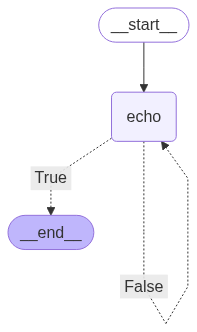

In [36]:
# PNG view ────────────────
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display

display(
    Image(
        dynamic_graph.get_graph().draw_mermaid_png(          # swap in your graph
            draw_method=MermaidDrawMethod.API               # LOCAL also works if graphviz installed
        )
    )
)

In [37]:
# Test the dynamic graph
print("Testing Dynamic Conversation Graph:")
print("-" * 40)

# Test 1: Normal conversation
messages = [
    HumanMessage(content="Hello there!"),
    HumanMessage(content="This is cool"),
    HumanMessage(content="bye")
]

for msg in messages:
    print(f"\nUser: {msg.content}")
    result = dynamic_graph.invoke({"messages": [msg]})
    print(f"Bot: {result['messages'][-1].content}")


Testing Dynamic Conversation Graph:
----------------------------------------

User: Hello there!
Bot: You said: 'Hello there!'. What else would you like to say?

User: This is cool
Bot: You said: 'This is cool'. What else would you like to say?

User: bye
Bot: You said: 'bye'. What else would you like to say?


## Exercise 5: Building an Advanced Stateful Conversation System

Now let's create a new system that combines everything we've learned with additional features:
- **Memory Window Management**: Keep only recent messages to manage context
- **Conversation Summarization**: Create summaries of the conversation
- **Sentiment Analysis**: Analyze the emotional tone of the conversation

### Advanced State Management Concepts:

1. **Memory Windows**: Prevent unbounded growth of message history
2. **Context Preservation**: Maintain important information even when pruning messages
3. **Multi-Node Processing**: Chain multiple processing steps together
4. **State Enrichment**: Add analytical insights to the conversation


In [38]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate

# Initialize LLM for advanced features
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

class AdvancedState(TypedDict):
    """
    Advanced state container with multiple tracking fields.
    
    This implementation demonstrates:
    1. Message history with proper LangGraph annotations
    2. Conversation summaries for context retention
    3. Sentiment tracking for emotional intelligence
    4. Memory window control for efficient processing
    """
    messages: Annotated[list[BaseMessage], add_messages]
    summary: str
    sentiment: str
    window_size: int


In [39]:
def manage_memory_window(state: AdvancedState) -> AdvancedState:
    """
    Manage the message window to prevent unbounded growth.
    
    This is crucial for production systems to:
    1. Control memory usage
    2. Maintain relevant context
    3. Improve processing speed
    """
    window_size = state.get("window_size", 5)
    messages = state["messages"]
    
    # Keep only the last N messages
    if len(messages) > window_size:
        # Always keep system messages plus the window
        system_messages = [m for m in messages if isinstance(m, SystemMessage)]
        recent_messages = messages[-window_size:]
        
        # Combine system messages with recent messages
        pruned_messages = system_messages + recent_messages
        
        return {"messages": pruned_messages}
    
    return state


In [40]:
def summarize_conversation(state: AdvancedState) -> AdvancedState:
    """
    Create a summary of the conversation.
    
    This helps maintain context even when messages are pruned.
    """
    # Get recent messages for summarization
    window_size = state.get("window_size", 5)
    messages_to_summarize = state["messages"][-window_size:]
    
    # Create text from messages
    conversation_text = "\n".join([
        f"{type(m).__name__}: {m.content}" 
        for m in messages_to_summarize
    ])
    
    # Create summary using LLM
    prompt = PromptTemplate(
        input_variables=["conversation"],
        template="Summarize this conversation in one concise sentence:\n\n{conversation}\n\nSummary:"
    )
    
    summary = llm.invoke(prompt.format(conversation=conversation_text)).content.strip()
    
    return {"summary": summary}


In [41]:
def analyze_sentiment(state: AdvancedState) -> AdvancedState:
    """
    Analyze the sentiment of the conversation.
    
    This enables sentiment-aware responses and better user experience.
    """
    # Use the summary for sentiment analysis (more efficient)
    text_to_analyze = state.get("summary", "")
    
    if not text_to_analyze:
        # Fallback to last message if no summary
        if state["messages"]:
            text_to_analyze = state["messages"][-1].content
        else:
            return {"sentiment": "neutral"}
    
    # Analyze sentiment using LLM
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Analyze the sentiment of this text. Respond with only one word: positive, negative, or neutral.\n\nText: {text}\n\nSentiment:"
    )
    
    sentiment = llm.invoke(prompt.format(text=text_to_analyze)).content.strip().lower()
    
    # Ensure valid sentiment
    if sentiment not in ["positive", "negative", "neutral"]:
        sentiment = "neutral"
    
    return {"sentiment": sentiment}


In [42]:
def respond_with_sentiment(state: AdvancedState) -> AdvancedState:
    """
    Generate a response that takes sentiment into account.
    
    This creates more empathetic and contextually appropriate responses.
    """
    sentiment = state.get("sentiment", "neutral")
    summary = state.get("summary", "No summary available")
    
    # Create sentiment-aware response
    if sentiment == "positive":
        response = f"I'm glad to hear things are going well! Based on our conversation: {summary}"
    elif sentiment == "negative":
        response = f"I understand this might be challenging. Let me help. Our discussion so far: {summary}"
    else:
        response = f"Thank you for sharing. Here's what we've discussed: {summary}"
    
    return {"messages": [AIMessage(content=response)]}


In [43]:
# Build the advanced conversation graph
advanced_builder = StateGraph(AdvancedState)

# Add all nodes
advanced_builder.add_node("memory_manager", manage_memory_window)
advanced_builder.add_node("summarizer", summarize_conversation)
advanced_builder.add_node("sentiment_analyzer", analyze_sentiment)
advanced_builder.add_node("responder", respond_with_sentiment)

# Create the processing pipeline
advanced_builder.set_entry_point("memory_manager")
advanced_builder.add_edge("memory_manager", "summarizer")
advanced_builder.add_edge("summarizer", "sentiment_analyzer")
advanced_builder.add_edge("sentiment_analyzer", "responder")
advanced_builder.add_edge("responder", END)

# Compile the graph
advanced_graph = advanced_builder.compile()


In [44]:
# Test the advanced system
print("Testing Advanced Stateful Conversation System:")
print("-" * 50)

# Test with positive sentiment
positive_state = {
    "messages": [
        HumanMessage(content="I just got promoted at work!"),
        AIMessage(content="That's wonderful news!"),
        HumanMessage(content="Yes, I'm really excited about the new opportunities.")
    ],
    "summary": "",
    "sentiment": "",
    "window_size": 5
}

print("Test 1: Positive Sentiment")
result = advanced_graph.invoke(positive_state)
print(f"Summary: {result['summary']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['messages'][-1].content}")

print("\n" + "="*50 + "\n")

# Test with negative sentiment
negative_state = {
    "messages": [
        HumanMessage(content="I'm having a really tough day"),
        AIMessage(content="I'm sorry to hear that"),
        HumanMessage(content="Everything seems to be going wrong")
    ],
    "summary": "",
    "sentiment": "",
    "window_size": 5
}

print("Test 2: Negative Sentiment")
result = advanced_graph.invoke(negative_state)
print(f"Summary: {result['summary']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['messages'][-1].content}")


Testing Advanced Stateful Conversation System:
--------------------------------------------------
Test 1: Positive Sentiment
Summary: The human shares their excitement about a recent promotion at work, and the AI responds positively.
Sentiment: positive
Response: I'm glad to hear things are going well! Based on our conversation: The human shares their excitement about a recent promotion at work, and the AI responds positively.


Test 2: Negative Sentiment
Summary: The person is experiencing a difficult day with multiple issues, and the AI expresses sympathy.
Sentiment: negative
Response: I understand this might be challenging. Let me help. Our discussion so far: The person is experiencing a difficult day with multiple issues, and the AI expresses sympathy.


## Visualizing Our Graphs

One of the powerful features of LangGraph is the ability to visualize our workflows. Let's visualize the advanced graph we just created:


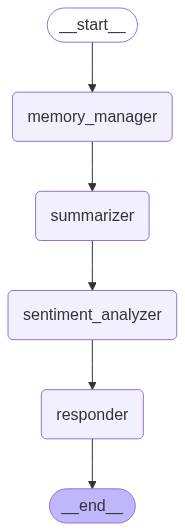

In [45]:
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

# Visualize the advanced graph
try:
    display(
        Image(
            advanced_graph.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )
except Exception as e:
    print(f"Error generating visualization: {e}")
    print("\nGraph structure:")
    print("memory_manager -> summarizer -> sentiment_analyzer -> responder -> END")


## Key Takeaways and Best Practices

### 1. State Management Best Practices
- **Always use TypedDict** for type safety and clear documentation
- **Use Annotated with add_messages** for proper message handling
- **Initialize all state fields** to avoid KeyError exceptions
- **Preserve state fields** when updating - only update what changes

### 2. Graph Design Principles
- **Start simple** and add complexity incrementally
- **Use meaningful node names** that describe their function
- **Handle edge cases** (empty states, missing fields)
- **Add proper exit conditions** to prevent infinite loops

### 3. Message Handling
- **Use typed messages** (HumanMessage, AIMessage, etc.) for clarity
- **Filter messages by type** when processing specific roles
- **Maintain message order** for conversation coherence
- **Consider message windows** for production systems

### 4. Advanced Features
- **Memory management** prevents unbounded growth
- **Summarization** preserves context when pruning
- **Sentiment analysis** enables empathetic responses
- **Multi-node pipelines** allow complex processing

### 5. Common Pitfalls to Avoid
- Forgetting to check if messages/fields exist
- Not handling empty or invalid states
- Creating circular dependencies in graphs
- Ignoring memory constraints in production

## Next Steps

1. **Experiment with the code** - Modify the examples to suit your needs
2. **Add persistence** - Save and restore conversation state
3. **Integrate tools** - Add function calling and external APIs
4. **Build production systems** - Add error handling and monitoring
5. **Explore advanced patterns** - Parallel execution, sub-graphs, and more

For more information, check out:
- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [LangChain Documentation](https://python.langchain.com/)
- [AI Product Engineer Tutorials](https://aiproduct.engineer/tutorials)
